# IFS calibration

1. Run normal deconvolution routine
2. construct a high-resolution, flattened polychrome
3. For x, y offset determination, run a grid search by interpolating the high-res polychrome around
4. Find the minimum/maximum of the heatmap

In [1]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=20)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=20)
plt.rc('image',origin='lower',interpolation='nearest')

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.tools.image import Image
from crispy.PISCESparams import Params
# from crispy.params import Params
codefolder = '../../../crispy'
par = Params(codefolder)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from crispy.IFS import reduceIFSMap
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='lstsq',smoothbad=False,hires=True)


crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/BB.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_resid.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_model.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_hires_model.fits
crispy - INFO - Elapsed time: 35.437632s


## Construct high-resolution polychrome cube

In [4]:
from crispy.tools.locate_psflets import locatePSFlets,PSFLets
from crispy.tools.image import Image
from crispy.tools.reduction import calculateWaveList
import glob
from astropy.io import fits as pyf
from crispy.tools.wavecal import make_hires_polychrome

lam = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]
log.info("Computing wavelength values at pixel centers")
psftool = PSFLets()
psftool.genpixsol(par,lam, allcoef, order=3,lam1=min(lam)/1.05, lam2=max(lam)*1.05)
# psftool.savepixsol(outdir=par.wavecalDir)

xindx = np.arange(-par.nlens/2, par.nlens/2)
xindx, yindx = np.meshgrid(xindx, xindx)

hires_list = np.sort(glob.glob(par.wavecalDir + 'hires_psflets_lam???.fits'))
hires_arrs = [pyf.open(filename)[0].data for filename in hires_list]

lam_midpts,lam_endpts=calculateWaveList(par,lam,method='lstsq')
Nspec = len(lam_endpts)

ysize,xsize = Image(par.codeRoot+"/Inputs/BB.fits").data.shape

hirespoly = np.zeros((Nspec - 1, ysize*upsample, xsize*upsample))


upsample = 3
for i in range(Nspec - 1):
    print("Slice %d" % i)
    hirespoly[i] = (lam_endpts[i + 1]-lam_endpts[i])*make_hires_polychrome(lam_endpts[i], lam_endpts[i + 1],
                                              hires_arrs, lam, psftool, 
                                              allcoef, xindx, yindx,ysize,xsize,upsample=upsample)
    


crispy - INFO - Computing wavelength values at pixel centers
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/BB.fits
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10


In [7]:
outkey = pyf.HDUList(pyf.PrimaryHDU(hirespoly.astype(np.float32)))
outkey.writeto(par.wavecalDir + 'hiresPolyChromeR%d.fits.gz' % (par.R), clobber=True)


In [3]:
from crispy.tools.detutils import frebin


In [152]:
BB = Image(par.codeRoot+"/Inputs/BB.fits").data
hires = Image(par.exportDir+"/BB_red_lstsq_hires_model.fits").data
normalres = Image(par.exportDir+"/BB_red_lstsq_model.fits").data
hires_rebinned = frebin(hires,normalres.T.shape)
print hires_rebinned.shape
print normalres.shape

crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/BB.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB_red_lstsq_hires_model.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB_red_lstsq_model.fits
(1032, 1056)
(1032, 1056)


crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_hires_resid.fits


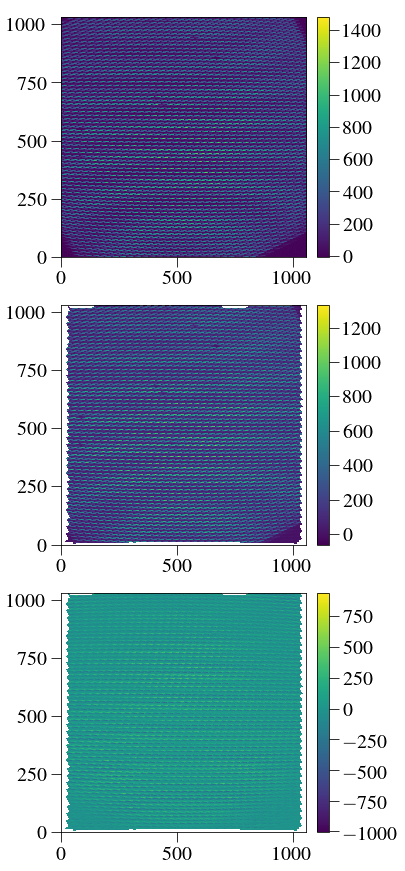

In [153]:
plt.figure(figsize = (5,15))
plt.subplot(311)
plt.imshow(BB)
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(312)
plt.imshow(hires_rebinned)
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(313)
plt.imshow(hires_rebinned-BB)
plt.colorbar(fraction=0.046, pad=0.04)

Image(data=hires_rebinned-BB).write(par.exportDir+"/BB_red_lstsq_hires_resid.fits")


In [154]:
from scipy import ndimage

hires[np.isnan(hires)] = 0.0
smooth_model = ndimage.spline_filter(hires)

crispy - INFO - Iteration 0 out of 10
crispy - INFO - Iteration 1 out of 10
crispy - INFO - Iteration 2 out of 10
crispy - INFO - Iteration 3 out of 10
crispy - INFO - Iteration 4 out of 10
crispy - INFO - Iteration 5 out of 10
crispy - INFO - Iteration 6 out of 10
crispy - INFO - Iteration 7 out of 10
crispy - INFO - Iteration 8 out of 10
crispy - INFO - Iteration 9 out of 10
crispy - INFO - Fitted offsets: 0.56, 0.44


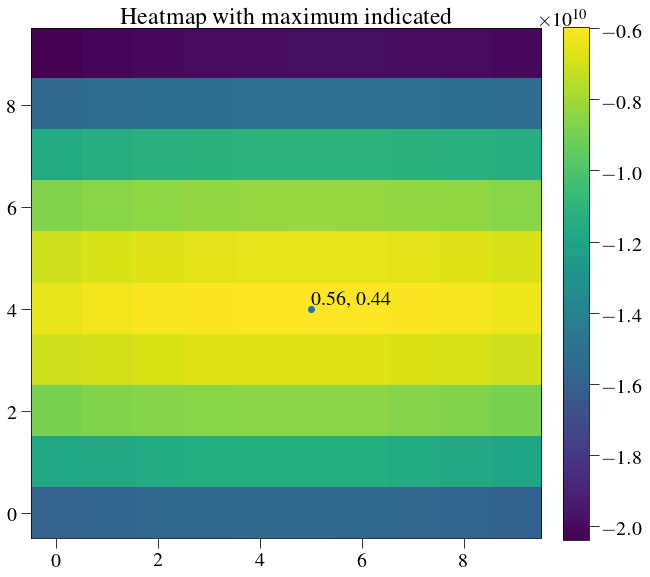

In [22]:
def model_func2d(offx,offy):
    shifted = ndimage.interpolation.shift(smooth_model,[offy,offx],prefilter=False)
    return frebin(shifted,BB.T.shape)

upsample=3
npixmin = 0.0
npixmax = 1
nx = 10
ny = 10
grid = np.zeros((nx,ny))
yoffsets,xoffsets = np.meshgrid(np.linspace(npixmin,npixmax,nx),np.linspace(npixmin,npixmax,ny))
for ox in range(nx):
    log.info('Iteration %d out of %d' % (ox+1,nx))
    for oy in range(ny):
        grid[oy,ox] = np.sum((model_func2d(xoffsets[ox,oy]*upsample,yoffsets[ox,oy]*upsample)-BB)**2)

coords = np.unravel_index(grid.argmin(), grid.shape)
log.info('Fitted offsets: %.2f, %.2f' % (yoffsets[coords],xoffsets[coords]))
plt.figure(figsize=(10,10))
plt.imshow(-grid)
plt.colorbar(fraction=0.046, pad=0.04)
plt.scatter([coords[1]],[coords[0]])
plt.annotate('%.2f, %.2f' % (yoffsets[coords],xoffsets[coords]),xy=coords[::-1],ha='left',va='bottom')
plt.title('Heatmap with maximum indicated')


In [23]:
newmodel = model_func2d(xoffsets[ox,oy]*upsample,yoffsets[coords]*upsample)
Image(data=newmodel-BB).write(par.exportDir+"/BB_red_lstsq_hires_resid_new.fits")


crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_hires_resid_new.fits


In [27]:
print yoffsets
print grid[coords]
print np.nansum((Image(par.exportDir+"/BB_red_lstsq_resid.fits").data-BB)**2)

[[ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
   0.66666667  0.77777778  0.88888889  1.        ]
 [ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
   0.66666667  0.77777778  0.88888889  1.        ]
 [ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
   0.66666667  0.77777778  0.88888889  1.        ]
 [ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
   0.66666667  0.77777778  0.88888889  1.        ]
 [ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
   0.66666667  0.77777778  0.88888889  1.        ]
 [ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
   0.66666667  0.77777778  0.88888889  1.        ]
 [ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
   0.66666667  0.77777778  0.88888889  1.        ]
 [ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
   0.66666667  0.77777778  0.88888889  1.        ]


## Repeat now by dividing up the image into small chunks

In [165]:
hires = Image(par.exportDir+"/BB_red_lstsq_hires_model.fits").data
hires[np.isnan(hires)] = 0.0
smooth_model = ndimage.spline_filter(hires)
nchunks = 8 # power of 2
list_offsets = np.zeros((2,nchunks,nchunks))
BBsplit = np.split(BB,nchunks,axis=0)
BBsplithires = np.split(hires,nchunks,axis=0)

new_polychrome = np.zeros_like(BB)
print(BBsplit[0].shape)
plt.figure(figsize=(15,10))
for i, chunk in enumerate(BBsplit):
#     if i==0:
#         chunkhires = BBsplithires[i]
#         indiv = np.split(chunk,nchunks,axis=1)[0]
#         indiv_hires = np.split(chunkhires,nchunks,axis=1)[0]
#         plt.subplot(131)
#         plt.imshow(indiv)
#         plt.subplot(132)
#         plt.imshow(indiv_hires)
#         plt.subplot(133)
#         plt.imshow(frebin(indiv_hires,indiv.T.shape))
    chunkhires = BBsplithires[i]
    indivlist = np.split(chunk,nchunks,axis=1)
    for j, indiv in enumerate(indivlist):
        log.info('Chunk (%d,%d) out of (%d,%d)' % (i,j,nchunks-1,nchunks-1))
        indiv_hires = np.split(chunkhires,nchunks,axis=1)[j]
        smooth_model = ndimage.spline_filter(indiv_hires)
        def model_func2d(offx,offy):
            shifted = ndimage.interpolation.shift(smooth_model,[offy,offx],prefilter=False)
            return frebin(shifted,indiv.T.shape)

        upsample=3
        npixmin = 0.1
        npixmax = 0.8
        nx = 20
        ny = 20
        grid = np.zeros((nx,ny))
        yoffsets,xoffsets = np.meshgrid(np.linspace(npixmin,npixmax,nx),np.linspace(npixmin,npixmax,ny))
        for ox in range(nx):
#             log.info('Iteration %d out of %d' % (ox+1,nx))
            for oy in range(ny):
                grid[oy,ox] = np.sum((model_func2d(xoffsets[oy,ox]*upsample,yoffsets[oy,ox]*upsample)-indiv)**2)

        coords = np.unravel_index(grid.argmin(), grid.shape)
        list_offsets[:,i,j] = (xoffsets[coords],yoffsets[coords])
        new_polychrome[i*indiv.shape[0]:(i+1)*indiv.shape[0],
                       j*indiv.shape[1]:(j+1)*indiv.shape[1]] = model_func2d(xoffsets[coords]*upsample,
                                                                             yoffsets[coords]*upsample)


crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB_red_lstsq_hires_model.fits
(129, 1056)
crispy - INFO - Chunk (0,0) out of (7,7)
crispy - INFO - Chunk (0,1) out of (7,7)
crispy - INFO - Chunk (0,2) out of (7,7)
crispy - INFO - Chunk (0,3) out of (7,7)
crispy - INFO - Chunk (0,4) out of (7,7)
crispy - INFO - Chunk (0,5) out of (7,7)
crispy - INFO - Chunk (0,6) out of (7,7)
crispy - INFO - Chunk (0,7) out of (7,7)
crispy - INFO - Chunk (1,0) out of (7,7)
crispy - INFO - Chunk (1,1) out of (7,7)
crispy - INFO - Chunk (1,2) out of (7,7)
crispy - INFO - Chunk (1,3) out of (7,7)
crispy - INFO - Chunk (1,4) out of (7,7)
crispy - INFO - Chunk (1,5) out of (7,7)
crispy - INFO - Chunk (1,6) out of (7,7)
crispy - INFO - Chunk (1,7) out of (7,7)
crispy - INFO - Chunk (2,0) out of (7,7)
crispy - INFO - Chunk (2,1) out of (7,7)
crispy - INFO - Chunk (2,2) out of (7,7)
crispy - INFO - Chunk (2,3) out of (7,7)
crispy - INFO - Chunk (2,4) out of (7,7)
crispy - INFO - Chunk (2,5) ou

In [166]:
print list_offsets[1]

[[ 0.1         0.28421053  0.43157895  0.43157895  0.43157895  0.39473684
   0.13684211  0.1       ]
 [ 0.50526316  0.57894737  0.54210526  0.46842105  0.46842105  0.57894737
   0.61578947  0.32105263]
 [ 0.50526316  0.50526316  0.43157895  0.39473684  0.39473684  0.46842105
   0.54210526  0.50526316]
 [ 0.46842105  0.43157895  0.39473684  0.32105263  0.32105263  0.32105263
   0.46842105  0.50526316]
 [ 0.43157895  0.46842105  0.43157895  0.43157895  0.43157895  0.43157895
   0.32105263  0.46842105]
 [ 0.39473684  0.46842105  0.50526316  0.54210526  0.54210526  0.46842105
   0.32105263  0.32105263]
 [ 0.39473684  0.43157895  0.50526316  0.54210526  0.54210526  0.43157895
   0.32105263  0.46842105]
 [ 0.54210526  0.32105263  0.32105263  0.32105263  0.32105263  0.32105263
   0.46842105  0.8       ]]


In [176]:
# interpolate offset grid
from scipy.interpolate import interp2d
y = np.arange(0.5,nchunks)*indiv.shape[0]*upsample
x = np.arange(0.5,nchunks)*indiv.shape[1]*upsample
offyinterp = interp2d(x,y,list_offsets[0], kind='linear')
offxinterp = interp2d(x,y,list_offsets[1], kind='linear')

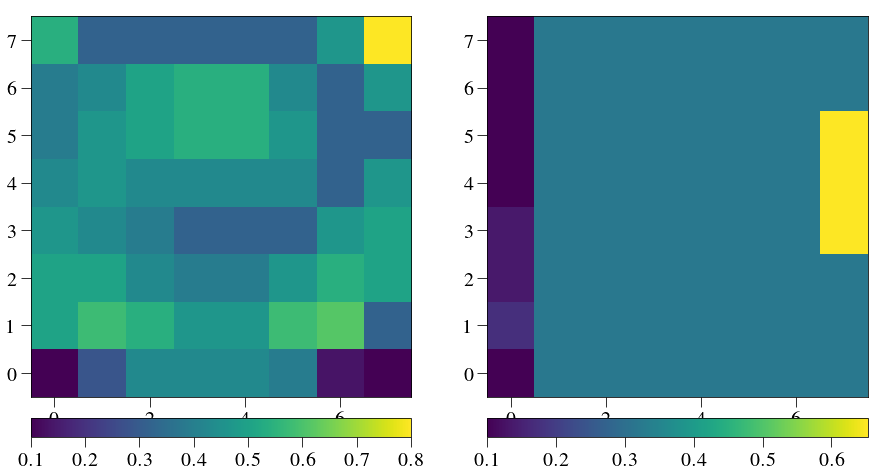

In [177]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(list_offsets[1])
plt.colorbar(fraction=0.046, pad=0.04,orientation='horizontal')
plt.subplot(122)
plt.imshow(list_offsets[0])
plt.colorbar(fraction=0.046, pad=0.04,orientation='horizontal')

In [178]:
y = np.arange(hires.shape[0])
x = np.arange(hires.shape[1])
valx = offxinterp(x,y)
valy = offyinterp(x,y)

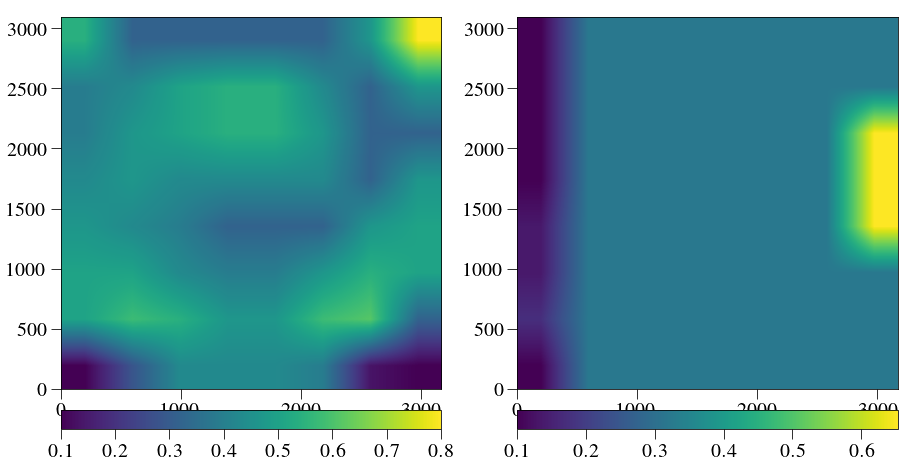

In [179]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(valx)
plt.colorbar(fraction=0.046, pad=0.04,orientation='horizontal')
plt.subplot(122)
plt.imshow(valy)
plt.colorbar(fraction=0.046, pad=0.04,orientation='horizontal')


In [180]:
hires = Image(par.exportDir+"/BB_red_lstsq_hires_model.fits").data
hires[np.isnan(hires)] = 0.0
print valy.shape,valx.shape
print BB.shape
xx,yy=np.meshgrid(x.astype(np.float),y.astype(np.float))
print yy.shape
yy -= valx*upsample
xx -= valy*upsample
new_hires_poly = ndimage.map_coordinates(hires,[yy,xx],order=3)
hires = Image(par.exportDir+"/BB_red_lstsq_hires_model.fits").data
new_poly = frebin(new_hires_poly,BB.T.shape)
new_hires = frebin(hires,BB.T.shape)
diff = BB-new_poly
diff[np.isnan(new_hires)] = 0.0
Image(data=diff).write(par.exportDir+"/BB_red_lstsq_new_poly_resid.fits")


crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB_red_lstsq_hires_model.fits
(3096, 3168) (3096, 3168)
(1032, 1056)
(3096, 3168)
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB_red_lstsq_hires_model.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_new_poly_resid.fits


6.12659e+09
1.08441e+09
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB_red_lstsq_resid.fits
1.11166e+11


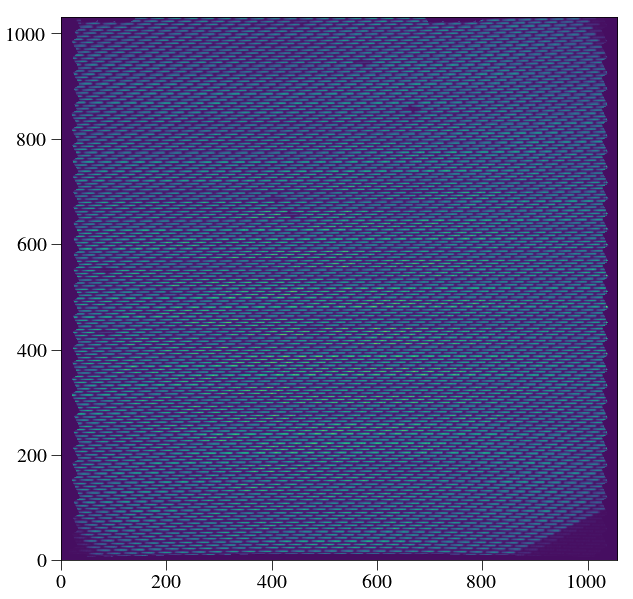

In [181]:
print np.nansum((BB-new_polychrome)**2)
print np.nansum((diff)**2)

print np.nansum((Image(par.exportDir+"/BB_red_lstsq_resid.fits").data-BB)**2)
plt.figure(figsize=(15,10))
plt.imshow(new_poly)

In [151]:
Image(data=BB-new_polychrome).write(par.exportDir+"/BB_red_lstsq_new_polychrome_resid.fits")


crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_new_polychrome_resid.fits


## Now edit polychrome

In [185]:
old_hires_polychrome = Image(par.wavecalDir+'hiresPolyChromeR70.fits.gz').data
print old_hires_polychrome.shape
new_polychrome = np.zeros_like(Image(par.wavecalDir+'polychromeR70_old.fits').data)
xx,yy=np.meshgrid(x.astype(np.float),y.astype(np.float))
yy -= valx*upsample
xx -= valy*upsample
for iwav in range(old_hires_polychrome.shape[0]):
    new_polychrome[iwav] = frebin(ndimage.map_coordinates(old_hires_polychrome[iwav],[yy,xx],order=3),new_polychrome[iwav].T.shape)


crispy - INFO - Read data from HDU 0 of ../../../crispy/ReferenceFiles/Calibra_170425/hiresPolyChromeR70.fits.gz
(11, 3096, 3168)
crispy - INFO - Read data from HDU 0 of ../../../crispy/ReferenceFiles/Calibra_170425/polychromeR70_old.fits
crispy - INFO - Writing data to ../../../crispy/ReferenceFiles/Calibra_170425/polychromeR70.fits


In [189]:
Image(data=np.sum(new_polychrome,axis=0)).write(par.wavecalDir+'polychromeR70stack.fits')
from astropy.io import fits
out = fits.HDUList(fits.PrimaryHDU(new_polychrome.astype(np.float32)))
out.writeto(par.wavecalDir+'polychromeR%d.fits' % (par.R), clobber=True)


crispy - INFO - Writing data to ../../../crispy/ReferenceFiles/Calibra_170425/polychromeR70stack.fits


In [190]:
from crispy.IFS import reduceIFSMap
cube = reduceIFSMap(par,par.codeRoot+"/Inputs/BB.fits",method='lstsq',smoothbad=False,hires=True)


crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/BB.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_resid.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_model.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/BB_red_lstsq_hires_model.fits
crispy - INFO - Elapsed time: 36.854684s


In [193]:
print np.nansum(Image(par.exportDir + '/BB_red_lstsq_resid.fits').data**2)
print np.nansum(Image(par.exportDir + '/BB/BB_red_lstsq_resid.fits').data**2)

crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB_red_lstsq_resid.fits
9.70901e+08
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/BB/BB_red_lstsq_resid.fits
1.89795e+09
